# TP noté "Machine Learning 1" <a class="tocSkip">
11 janvier 2023


Les données proposées dans ce sujet sont des données synthétiques qui nous permettront d'examiner et mettre en oeuvre plusieurs des méthodes rencontrées dans l'unité. Ce sujet traitera ainsi de

- régression de Poisson et régression linéaire
- clustering (avec KMeans)
- discrimination avec une régression logistique
- estimation des performances par validation croisée
- estimation d'incertitudes par bootstrap

**Instructions** 

- répondre aux questions en utilisant _le langage de votre choix_, soit dans un Notebook Jupyter, soit dans un notebook Rstudio
- vous ferez les calculs et tracerez les figures demandées. Vous insèrerez vos commentaires dans une cellule markdown/texte. _**Il est impératif de commenter ce que vous faites, pourquoi, et les résultats que vous obtenez ; le code seul ne vous rapportera qu'un peu plus de la moitié des points.**_  
- vous pouvez même utiliser plusieurs langages si vous le souhaitez
- tous documents autorisés
- interdiction de communiquer avec d'autres intelligences, humaines ou artificielles. 
- en fin de session, vous rendrez votre notebook en le téléversant sur icampus


**Les parties 2, 3, 4, 5 (partiellement) sont indépendantes** 

## 1 - Données

- Charger le fichier `Data_2023.csv`.Vous appellerez `df` le dataframe.  
- Combien ce fichier contient-il d'exemples, de variables ? 
- Quelles peuvent être les variables catégorielles ? 


In [73]:
# Importation des différents packages requis pour les différentes tâches

# Importation de 'pandas' (lecture de fichier et gestion de dataframe)
import pandas as pd

# Importation de 'seaborn' pour les représentations
import seaborn as sns

# Importe les fichiers fournit par le professeur 
import LinearRegression_in_Python_like_in_R_2023
import GLMRegression

# Importation de 'pyplot' pour afficher les graphiques
import matplotlib.pyplot as plt

# Importation de 'accuracy_score' & 'mean_squared_error' pour la régression logistique depuis sklearn
from sklearn.metrics import accuracy_score, mean_squared_error

# Importation de 'train_test_split', 'cross_val_score' pour la régression logistique depuis sklearn
from sklearn.model_selection import train_test_split, cross_val_score

# Importation de 'LogisticRegression' pour la cross-validation score (modèle compatible)
from sklearn.linear_model import LogisticRegression

# Importation de 'statsmodels.api' pour récupérer un modèle de GLM
import statsmodels.api as sm

In [74]:
# Lecture du fichier .csv grâce à 'pandas' et on supprime les valeurs manquantes
df = pd.read_csv('Data_2023.csv').dropna()

# Récupère le nombre d'observations (lignes) et le nombre de variables (colonnes)
print(f"Nous dénombrons au total {df.shape[0]} observations, et on compte {df.shape[1]} variables.")

# Affichage des 5 premières valeurs pour visualiser les données
df.head()

Nous dénombrons au total 3639 observations, et on compte 10 variables.


,v1,v2,v3,v4,v5,v6,v7,v8,v9,r
0,-5.244266,A,-2.544469,-12,0,0.0,-7,-19,8,0
2,-7.882469,B,0.087773,-10,0,0.0,-11,-20,8,1
3,-7.155857,A,-0.713578,-13,0,1.0,-10,-24,7,1
4,2.257337,B,-2.380117,5,1,0.0,3,9,10,0
5,-7.760821,B,3.101712,-5,1,0.0,-10,-14,8,1


In [75]:
# Afin de déterminer les variables catégorielles, nous cherchons à récupérer différentes informations concernant le type et le contenu de chaque colonne
# Dans le cas de variables catégorielles, il est fréquent qu'il y ait peu de valeurs différentes (e.g : valeur binaire pour homme/femme) 
print(df.nunique())

v1    2435
v2       2
v3    3639
v4      24
v5       2
v6      61
v7      19
v8      45
v9      16
r        2
dtype: int64


On peut d'ores et déjà espérer voir les variables 'v2', 'v5' & 'r'.

- Examiner quelles sont les corrélations entre les différentes variables

<Axes: >

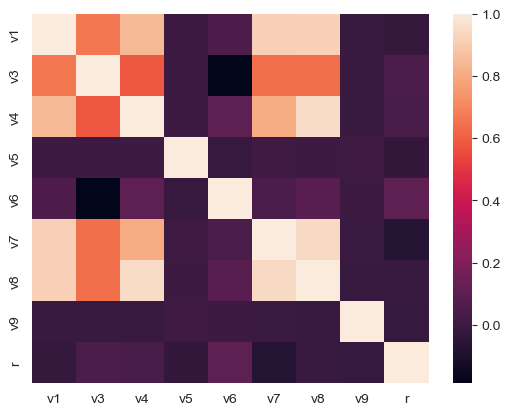

In [76]:
# Définit la matrice de corrélation selon les différentes variables numériques. En effet, il est difficile d'exprimer la corrélation de la colonne 
# 'v2' (corréler la valeur 'A' avec '-5.24' n'est pas évident !)...
correlation_matrix = df.corr(numeric_only = True)

# Affiche une heatmap carrée où chaque case exprime la corrélation des variables entre l'abscisse et l'ordonnée
sns.heatmap(df.corr(numeric_only = True))

In [77]:
# Création d'une liste contenant les paires de variables à haute corrélation (Corr(X,Y)>0.7)
duo_high_corr = []

# On parcourt chaque ligne de notre matrice de corrélation
for row in correlation_matrix.index:
    # Puis chaque colonne de cette même matrice
    for col in correlation_matrix.columns:
        # Si l'on observe une corrélation pour un couple (i,j) telle que cette dernière possède une valeur absolue supérieure à 0.7, on l'enregistre
        # Bien entendu, nous ne prendrons pas en compte les auto-corrélations qui sont toutes d'une valeur de 1 !
        if (correlation_matrix.loc[row, col] > 0.7 or correlation_matrix.loc[row, col] < -0.7) and row != col:
            # une fois dans cette condition, on ajoutera sous forme de tuple les index et la corrélation associée.
            duo_high_corr.append((row, col, correlation_matrix.loc[row, col]))


# Pour chaque duo de variables ayant une haute corrélation, on affiche les paires et la corrélation
for pair in duo_high_corr:
    print(f"Variables {pair[0]} and {pair[1]} have a correlation of {pair[2]:.2f}")

Variables v1 and v4 have a correlation of 0.84
Variables v1 and v7 have a correlation of 0.91
Variables v1 and v8 have a correlation of 0.92
Variables v4 and v1 have a correlation of 0.84
Variables v4 and v7 have a correlation of 0.80
Variables v4 and v8 have a correlation of 0.95
Variables v7 and v1 have a correlation of 0.91
Variables v7 and v4 have a correlation of 0.80
Variables v7 and v8 have a correlation of 0.94
Variables v8 and v1 have a correlation of 0.92
Variables v8 and v4 have a correlation of 0.95
Variables v8 and v7 have a correlation of 0.94


On observe donc des couples avec des corrélations importantes :
- 'v1' :
    - Corr(v1,v4) = 0.84
    - Corr(v1,v7) = 0.91
    - Corr(v1,v8) = 0.92
- 'v4' :
    - Corr(v4,v7) = 0.80
    - Corr(v4,v8) = 0.95
- 'v7' :
    - Corr(v7,v8) = 0.94

- Tracer les histogrammes des variables 1, 3, 5. Peut-on soupçonner qu'il y ait des sous ensembles d'exemples avec des comportements différents ? 

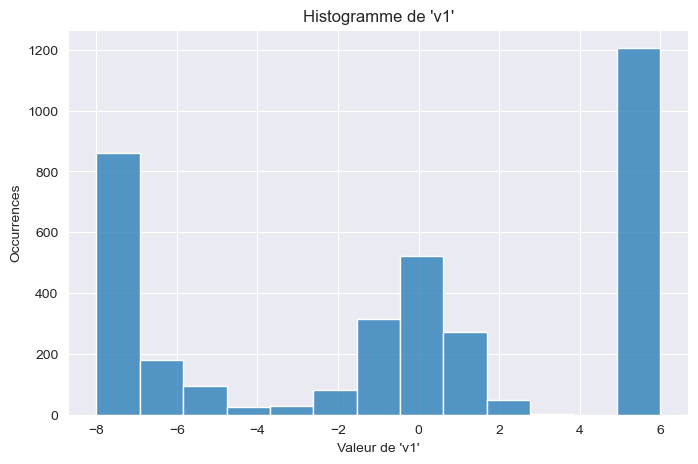

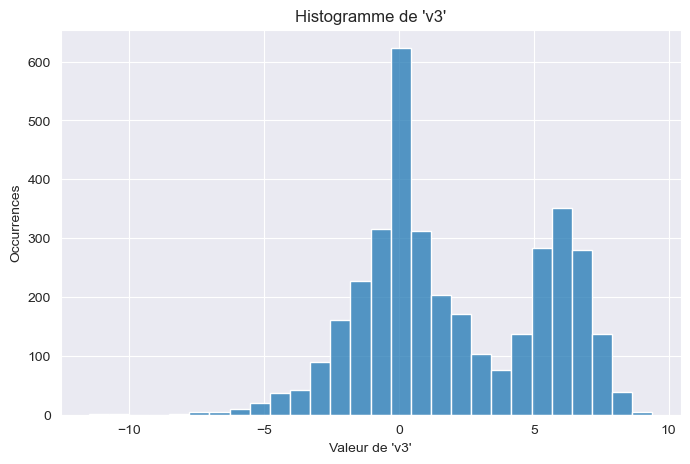

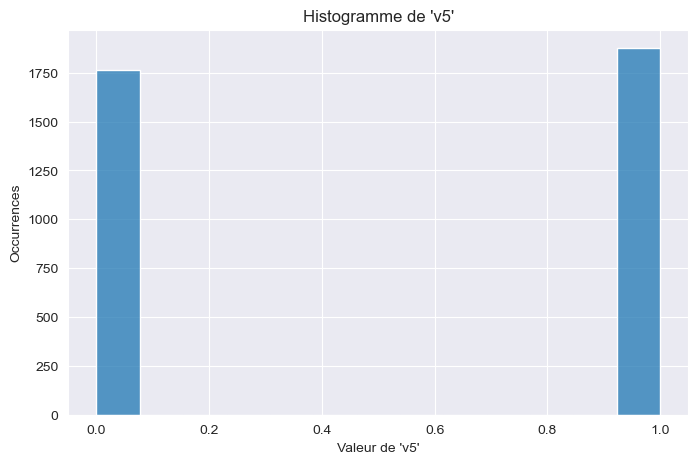

In [78]:
def plot_histograms(data = df, list_var=None, figsize = (8, 5)):
    """
    Fonction définissant un histogramme pour une liste de variables passée en paramètre
    :param data: jeu de données
    :param list_var: liste contenant le nom des variables à plot sous histogramme depuis le jeu de données
    :param figsize: (dimension du graphique)
    :return: un histogramme pour chaque élément dans list_var (3 par défaut)
    """
    if list_var is None:
        list_var = ['v1', 'v3', 'v5']
    for var in list_var:
        f, ax = plt.subplots(figsize=(8, 5))
        sns.histplot(data = df, x = var)
        ax.set_title(f"Histogramme de '{var}'")
        ax.set_xlabel(f"Valeur de '{var}'")
        ax.set_ylabel('Occurrences')

plot_histograms()

Pour la première variable **'v1'**, on observe globalement trois sous-ensembles. Le premier se situe vers **-7.5**, le second vers **0**, et enfin le dernier vers **5**.

Pour la seconde variable **'v2'**, on observe cette fois-ci deux sous-ensembles. Le premier se situe vers **0**, tandis que le second réside vers **6**.
 
Enfin, la dernière variable **"v3'** dénote clairement deux sous-ensembles. Cela semble être une distribution binaire.

## 2 - Conversion

La variable 2, `v2`, est catégorielle. Convertir cette variable en binaire, sur deux niveaux 0 et 1 ; et mettre à jour le dataframe `df`. Si vous n'arriviez pas à réaliser cette opération, charger le résultat `Data_2023b.csv` 

In [79]:
# On assigne un nouveau vecteur de valeurs à 'v2' où 'A' correspond à '0', et 'B' correspond à '1'
df['v2'] = df['v2'].replace({'A' : 0, 'B' : 1})

# On affiche les 5 premières valeurs de df
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,r
0,-5.244266,0,-2.544469,-12,0,0.0,-7,-19,8,0
2,-7.882469,1,0.087773,-10,0,0.0,-11,-20,8,1
3,-7.155857,0,-0.713578,-13,0,1.0,-10,-24,7,1
4,2.257337,1,-2.380117,5,1,0.0,3,9,10,0
5,-7.760821,1,3.101712,-5,1,0.0,-10,-14,8,1


In [80]:
# Permet de charger un jeu de données où v2 est catégorielle
df_b = pd.read_csv("Data_2023b.csv").dropna()

# On affiche les 5 premières valeurs de df_b
df_b.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,r
0,-5.244266,0,-2.544469,-12,0,0.0,-7,-19,8,0
2,-7.882469,1,0.087773,-10,0,0.0,-11,-20,8,1
3,-7.155857,0,-0.713578,-13,0,1.0,-10,-24,7,1
4,2.257337,1,-2.380117,5,1,0.0,3,9,10,0
5,-7.760821,1,3.101712,-5,1,0.0,-10,-14,8,1


On observe que le travail réalisé sur df est correcte. Pour cette raison, nous continuerons donc à exploiter df et non df_b car cela ne s'avère pas nécessaire.

## 3 - Discrimination (régression logistique)

La réponse est la variable `r`. On cherche à prédire cette réponse `r` à partir des variables explicatives `v1` à `v9`. Si le dataframe contient des variables supplémentaires, vous ne les utiliserez pas pour la discrimination. 

- Séparer les données en une base d'apprentissage et une base de test, avec un ratio 2/3, 1/3. 
- Apprendre une régression logistique (classe `LogisticRegression` en python/sklearn, fonction `glm` avec le paramètre `family=binomial` en R ou en Python avec statsmodels)
- Calculer les scores sur les bases de test et d'apprentissage. Ces scores sont-ils différents, commenter.
- Calculer la matrice de confusion (sur la base de test !). Quel est le taux de faux positifs ? NB - Sous python, vous pouvez utiliser `pd.crosstab` pour calculer cette matrice de confusion
- Apprendre la régression sur la base complète et calculer le score par validation croisée. Comparer le score obtenu par validation croisée à celui obtenu sur la base de test. Quel est l'intérêt de la validation croisée (au moins si les données sont en nombre faible) ?


NB - la variable `v6` présente des valeurs manquantes NA. **Si** cela posait des difficultés à la méthode que vous employez, ce n'est pas obligé, vous pouvez (i) soit supprimer les lignes correspondantes (ii) soit utiliser le fichier `Data_2023c.csv` 

In [81]:
# Dans un premier temps, on scinde notre dataframe en deux dataframes distincts X et Y

# Variables prédictives (axis = 1 : drop a column)
X = df.drop('r', axis=1)

# Variable à prédire
y = df['r']

# On split le jeu de données sous forme de 2/3 (train set) - 1/3 (test set), random_state = 42 : permet d'avoir des résultats reproductibles. Afin 
# de s'assurer que les résultats soient cohérents durant l'évaluation et durant votre correction, un facteur de reproductibilité est préférable...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [82]:
# On définit ici le modèle GLM avec le training set. On pensera à définir la famille exponentielle comme Binomial
modele_glm = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

# On représente ensuite grâce à la méthode disponible au sein du fichier 'GLMRegression.py' les informations relatives au modèle
GLMRegression.GLMsummary(modele_glm)

Dep. Variable:,r,No. Observations:,2438
Model:,GLM,Df Residuals:,2429
Model Family:,Binomial,Df Model:,8
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1613.0
Date:,"Sun, 07 Jan 2024",Deviance:,3226.1
Time:,16:17:07,Pearson chi2:,2.47e+03
No. Iterations:,4,Pseudo R-squ. (CS):,0.05875
Covariance Type:,nonrobust,,


,coef,std err,z,P>|z|,[0.025,0.975],p-value,Code
v1,-0.0027,0.023,-0.122,0.903,-0.047,0.041,9.031211e-01,
v2,-0.2194,0.089,-2.470,0.013,-0.393,-0.045,1.349418e-02,*
v3,0.1123,0.018,6.380,0.000,0.078,0.147,1.776306e-10,***
v4,0.0195,0.053,0.364,0.716,-0.085,0.124,7.159808e-01,
v5,-0.0383,0.089,-0.431,0.667,-0.213,0.136,6.668228e-01,
v6,0.0458,0.007,6.464,0.000,0.032,0.060,1.018276e-10,***
v7,-0.1725,0.055,-3.163,0.002,-0.279,-0.066,1.561776e-03,**
v8,0.0459,0.051,0.893,0.372,-0.055,0.147,3.718850e-01,
v9,-0.0224,0.009,-2.387,0.017,-0.041,-0.004,1.699264e-02,*


In [83]:
# Désormais, nous cherchons à évaluer les performances de notre modèle en terme de prédiction
y_train_pred = (modele_glm.predict(X_train) > 0.5).astype(int)
y_test_pred = (modele_glm.predict(X_test) > 0.5).astype(int)

print("Score_train :", accuracy_score(y_train, y_train_pred))
print("Score_test :", accuracy_score(y_test, y_test_pred))

# On affiche par ailleurs le MSE
print("MSE_train :", mean_squared_error(y_train, modele_glm.predict(X_train)))
print("MSE_test :", mean_squared_error(y_test, modele_glm.predict(X_test)))

Score_train : 0.603363412633306
Score_test : 0.6228143213988343
MSE_train : 0.23417469073219355
MSE_test : 0.23433498245122641


On observe que les scores de test sont légèrement meilleurs même s'ils restent relativement similaires. Ceci se trouve être une très bonne nouvelle montrant que le modèle ne semble pas réaliser d'overfitting. 

In [84]:
# On cherche à calculer la matrice de confusion sur le test set
confusion_matrix_test = pd.crosstab(y_test, y_test_pred)

# Exprime la matrice confusion (y_test : col_0; y_test_pred : r)
confusion_matrix_test

col_0,0,1
r,,
0,322,261
1,192,426


Le constat est le suivant :
- Vrai Positif (1,1) : 426
- **Faux Positif (1,0) : 192**
- Vrai Négatif (0,0) : 322
- Faux Négatif (0,1) : 261

In [85]:
# On calcule la specificity (TN / TN + FN)
Specificity = confusion_matrix_test[0][0] / confusion_matrix_test[0].sum()

# Désormais on calcule le False Positive Rate (1 - Specificity)
FPR = (1 - Specificity) * 100

print('Le taux de Faux Positif est de :', FPR, '%')

Le taux de Faux Positif est de : 37.35408560311284 %


N.B. on pourrait aussi calculer FPR tel que :

$$ FPR = \frac{FN}{TN + FN} \times 100\% $$

In [86]:
# On définit ici le modèle GLM. On utilisera sklearn pour pouvoir utiliser la fonction cross_val_score() de sklearn
modele_glm_full = LogisticRegression()

# On fait fit le modèle avec les données entières
modele_glm_full.fit(X, y)

# On calcule ensuite le score de la validation croisée (le score correspond à la moyenne de chaque score de cv) [On prendra cv entre 5 et 10]
mean_score_cv = cross_val_score(modele_glm_full, X, y, cv=5).mean()
print('Le cross-validation score moyen est de :', mean_score_cv)

# On regarde la différence de score
diff_score = accuracy_score(y_test, y_test_pred) - mean_score_cv 
print('La différence de score entre celui sur la base de test et celui ici de la cv est de :', diff_score)

Le cross-validation score moyen est de : 0.6059494838036791
La différence de score entre celui sur la base de test et celui ici de la cv est de : 0.016864837595155224


On observe que le score de la CV est légèrement inférieur à celui obtenu sur la base de test. La validation croisée a pour intérêt (spécialement pour les données en nombre faible) d'augmenter la robustesse du modèle avec plus de données.

## 4 - Régression linéaire et de Poisson

On est ennuyé avec les valeurs manquantes dans la variable `v6`. On décide d'imputer ces valeurs manquantes. Pour cela, on va tenter de prédire les valeurs manquantes à partir des autres variables. 

Sous R, vous pourrez utilier la fonction `lm`, et sous Python, vous pourrez charger l'équivalent par `from LinearRegression_in_Python_like_in_R import lm`. Vous pouvez également utiliser un modèle linéaire généralisé `glm` ; sous Python vous pourrez utiliser la fonction `glm` de statsmodels, et les fonctions de résumé et de diagnostique selon `from GLMRegression_in_Python_like_in_R import GLMsummary, glm_residplot`


- Suivant les outils que vous utilisez, vous pourrez ou pas utiliser la base `df` avec les valeurs manquantes. Le cas échéant, supprimer toutes les lignes sans NA pour la variable `v6`. Sous Python, vous pourrez utiliser `.dropna`, mais également`.notna()` pour accéder aux indices des lignes ne contenant pas de NA, et `.isna()` pour les lignes avec NA. 

**4.1 - Régression linéaire**
- Effectuer une prédiction lineaire de `v6` en fonction des autres variables explicatives (les variables en `v.`, pas `r`)
- Calculer l'erreur quadratique moyenne entre les valeurs exactes et prédites de `v6`. Vous pouvez éventuellement directement accéder à un prédicteur via une méthode `.predict()`, voire même directement aux residus via un attribut `.residuals` 
- Au vu des résultats, quelles sont les variables importantes
- Examiner les graphes de diagnostic. Pouvez vous soupçonner une non linarité, pourquoi ? 
- Effectuer une nouvelle prédiction en ajoutant la variable `v3**2`. Que devient alors l'erreur quadratique moyenne ? La variable v5 est-elle utile ? 
- Si vous ajoutiez `v5**2` plutôt que `v3**2`, quelle seraient l'erreur quadratique moyenne ? Commentaires. 

In [87]:
# Puis, nous cherchons à faire une prédiction linéaire de v6 en fonction des 'v*' sans mettre la variable 'r' (à prédire donc pas nécessaire)
v6_model_lm_1 = LinearRegression_in_Python_like_in_R_2023.lm('v6 ~ . - r', df)

# On affiche le modèle pour voir les informations
v6_model_lm_1.summary()

Call
smf.ols('v6 ~ . - r', data=...)

Coefficients:
           Estimate  Std. Error    t value      Pr(>|t|) code
Intercept  5.058715    0.483664  10.459143  3.029336e-25  ***
v1         0.177173    0.064144   2.762135  5.771373e-03   **
v2         0.219066    0.255833   0.856283  3.918977e-01     
v3        -0.929856    0.047613 -19.529450  7.589854e-81  ***
v4         0.181525    0.150430   1.206704  2.276247e-01     
v5        -0.306159    0.255852  -1.196625  2.315310e-01     
v7        -0.079451    0.153076  -0.519029  6.037718e-01     
v8         0.097024    0.145161   0.668391  5.039263e-01     
v9        -0.003912    0.054108  -0.072300  9.423675e-01     

Residuals:
         Min       1Q    Median        3Q        Max
0 -14.227685 -2.78448 -1.404669  0.171671  64.280515
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.1688 on 3630 degrees of freedom
Multiple R-squared:  0.1093,	Adjusted R-squared:  0.107 
F-statistic: 55.693 on 8 a

In [88]:
print("L'erreur moyenne quadratique (MSE) est de :", mean_squared_error(df['v6'], v6_model_lm_1.predict(df)))

L'erreur moyenne quadratique (MSE) est de : 51.264178813537875


On pourrait (conformément au .summary()), estimer que les variables importantes seraient 'v1' & 'v3'.

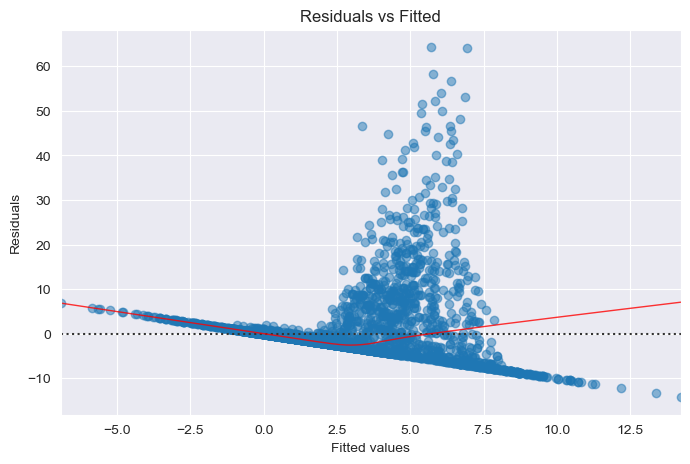

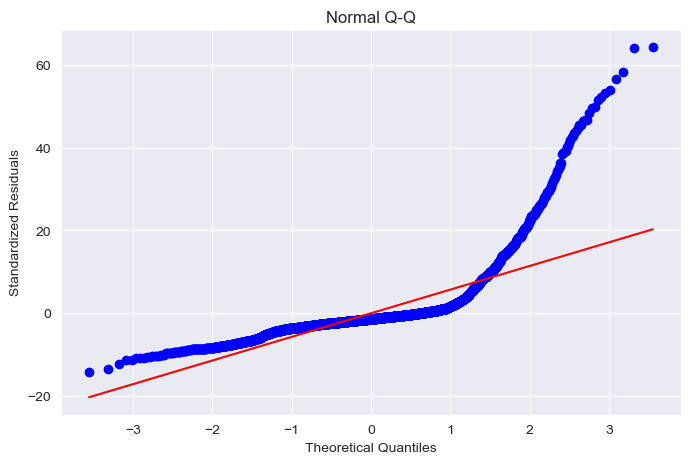

In [89]:
v6_model_lm_1.plot()

On observe ici une non-linéarité :
- Residuals vs Fitted : on observe une corrélation entre les fitted values et l'augmentation des residuals. Cela traduit une non-linéarité dans la relation avec les variables indépendantes ('v*'), et la variable dépendante ('r').
- Q-Q : on observe que les extrémités du graphique ne fit pas avec la ligne rouge qui représente le Q-Q d'une distribution normale. Ainsi, cela semble indiquer une non-linéarité du modèle. 

In [91]:
# Deuxième version du modèle avec v3**2
v6_model_lm_2 = LinearRegression_in_Python_like_in_R_2023.lm('v6 ~ . - r + I(v3**2)', df)

# On affiche le modèle pour voir les informations
v6_model_lm_2.summary()

Call
smf.ols('v6 ~ . - r + I(v3**2)', data=...)

Coefficients:
            Estimate  Std. Error    t value       Pr(>|t|) code
Intercept   7.328869    0.456185  16.065563   3.684655e-56  ***
v1          0.880029    0.065648  13.405174   4.977735e-40  ***
v2          0.419588    0.236575   1.773597   7.621361e-02    .
v3         -0.099470    0.055197  -1.802093   7.161374e-02    .
v4          0.125110    0.139044   0.899788   3.682928e-01     
v5         -0.499046    0.236581  -2.109402   3.497819e-02    *
v7         -0.252464    0.141641  -1.782415   7.476509e-02    .
v8          0.042293    0.134174   0.315207   7.526224e-01     
v9          0.025834    0.050020   0.516470   6.055576e-01     
I(v3 ** 2) -0.272614    0.010940 -24.919511  1.158909e-126  ***

Residuals:
        Min        1Q    Median        3Q        Max
0 -10.32473 -3.236347 -1.109787  0.892146  60.829774
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.6253 on 3629 degrees

In [92]:
print("L'erreur moyenne quadratique (MSE) est de :", mean_squared_error(df['v6'], v6_model_lm_2.predict(df)))

L'erreur moyenne quadratique (MSE) est de : 43.77376286079982


On observe que le MSE diminue. Cela souligne d'une augmentation de la pertinence du modèle. De plus, selon ce nouveau modèle, 'v5' semble jouer un rôle (très faible) au sein de la prédiction de 'v6'.

In [93]:
# Troisième version du modèle avec v5**2
v6_model_lm_3 = LinearRegression_in_Python_like_in_R_2023.lm('v6 ~ . - r + I(v5**2)', df)

# On affiche le modèle pour voir les informations
v6_model_lm_3.summary()

Call
smf.ols('v6 ~ . - r + I(v5**2)', data=...)

Coefficients:
            Estimate  Std. Error    t value      Pr(>|t|) code
Intercept   5.058715    0.483664  10.459143  3.029336e-25  ***
v1          0.177173    0.064144   2.762135  5.771373e-03   **
v2          0.219066    0.255833   0.856283  3.918977e-01     
v3         -0.929856    0.047613 -19.529450  7.589854e-81  ***
v4          0.181525    0.150430   1.206704  2.276247e-01     
v5         -0.153079    0.127926  -1.196625  2.315310e-01     
v7         -0.079451    0.153076  -0.519029  6.037718e-01     
v8          0.097024    0.145161   0.668391  5.039263e-01     
v9         -0.003912    0.054108  -0.072300  9.423675e-01     
I(v5 ** 2) -0.153079    0.127926  -1.196625  2.315310e-01     

Residuals:
         Min       1Q    Median        3Q        Max
0 -14.227685 -2.78448 -1.404669  0.171671  64.280515
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.1688 on 3630 degrees of freedom

In [94]:
print("L'erreur moyenne quadratique (MSE) est de :", mean_squared_error(df['v6'], v6_model_lm_3.predict(df)))

L'erreur moyenne quadratique (MSE) est de : 51.264178813537875


Il s'avère que la variable 'v5' ne joue pas un rôle qualitatif dans la prédiction de 'v6' se traduisant par l'augmentation du MSE.

**4.2 - Régression de Poisson**
- Effectuer une régression de Poisson de `v6` en fonction des autres variables explicatives (les variables en `v.`, pas `r`)
- Reprendre toutes les autres questions précémment traitées avec la régression linéaire (performances, variables à retenir, graphes de diagnostic, non-linéarité...)
- Comparer les résulats obtenus par les deux approches et commenter

In [ ]:
v6_model_poisson = smf.

**4.3 - Imputation**
- Rempacer les données manquantes dans `df` en prédisant les valeurs manquantes à l'aide du modèle linéaire. 
Si vous ne voyez pas comment faire, utiliser `Data_2023c.csv` dans la suite. 
- Enfin, calculez une régression logistique pour prédire la variable $r$ et évaluez les performances (sur une base de test ou par validation croisée, comme en 3). Comparez le score au score obtenu précédentemment.  

## Clustering

Comme vous l'avez peut-être observé, on soupçonne que les données puissent être en fait composées de différents *clusters*, qui possèderaient des caractéristiques différentes. L'idées est alors qu'on pourrait -- peut-être, améliorer les performances de discrimination et utilisant des modèles différents sur chacun des clusters. 

Au vu des histogrammes, on teste l'hypothèse de 3 clusters. 

- Utiliser la méthode kmeans pour définir 3 clusters. Tracer les histogrammes de répartition des labels identifiés par kmeans. 
- Ajouter au dataframe une colonne 'km_labels' contenant le label du cluster pour chaque exemple. 




NB - Sous Python 
```
from sklearn.cluster import KMeans
kmeans = KMeans(...
```



- Séparer votre dataframe en une base d'apprentissage `train` (les 3000 premières lignes) et une base de test `test` (les 1500 suivantes). 
- Pour chacun des groupes (vous pouvez filtrer vos données sur la valeur de la colonne 'km_labels')
   - calculer un modèle de régression logistique 
   - et les performances correspondantes (score $s_i$, taux de faux positifs $t_i$) sur la base de test, pour les exemples du même groupe
   - si $n_1$, $n_2$, $n_3$ sont les nombres d'exemples dans chacun des groupes, $s_1$, $s_2$, $s_3$ les scores dans chaque groupe, alors le score global sera 
$$
   s = \frac{n_1s_1  + n_2s_2 + n_3s_3} {n_1  + n_2 + n_3}
$$
   et pour le taux de faux positifs,
$$
   t = \frac{n_1t_1  + n_2t_2 + n_3t_3} {n_1  + n_2 + n_3}
$$
- Comparez les performances aux performances obtenues précédemment et commentez   

## Évaluation de la stabilité par bootstrap

- Ré-échantillonnez l'ensemble `train` et générez le même nombre d'échantillons, puis apprenez vos modèles et calculez le score global comme précédemment sur la base de test _inchangée_. 
- Effectuez ceci disons B=200 fois, en stockant les valeurs de scores et taux de faux positifs. 
- Tracez les histogrammes des valeurs obtenues
- Donnez les moyennes et intervalles de confiance correspondant. 